# Prevendo demanda de produtos.
        
        Aqui tentaremos prever vendas para 811 produtos.
        Nosso conjunto de dados possui registros de vendas de 52 semanas (1 ano) para cada produto.

        Isso significa que temos, originalmente, 811 séries temporais com 52 pontos de dados cada.
        Podemos abordar esse problema criando um modelo único para cada produto. Entretanto é pouco
        provável que essa seja a melhor forma de resolução. Já que haveria muitos modelos para dar
        manutenção, além disso, em ML mais dados geralmente significam melhores previsões. Assim, ao
        concatenar s séries em um único conjunto de dados, para treinar um único modelo, há muito 
        mais dados para se usar e isso pode ajudar o modelo a ter um desempenho melhor.
        
## Agenda
        1 - Preparação dos dados
            data.melt()
            Adicionando features
        2 - Baseline
        3 - Criando o modelo
            Melhorando-o
            Modificando a variável alvo
            Um modelo melhor
        Melhorando a solução

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
data = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv")
data = data.filter(regex=r'Product|W')
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


## 1 - Preparação dos dados
        Para treinar um único modelo que preveja várias séries temporais ao mesmo tempo,
        precisamos transformar os dados de maneira que cada linha se torne:
        código do produto, a semana, e a quantidade de vendas.
        
    Por hora temos:
        
        código_do_produto         semana0          semana1            ...
        
             produto1         quantia vendida    quantia vendida      ...
             produto2         quantia vendida    quantia vendida      ...
             produto3         quantia vendida    quantia vendida      ...
        
   **Queremos:**
        
        código_do_produto     semana     quantia_vendida   

             produto 1           0       quantia vendida
             produto 2           0       quantia vendida
             produto 3           0       quantia vendida
             produto 1           1       quantia vendida
             produto 2           1       quantia vendida
             produto 3           1       quantia vendida
             produto 1           2       quantia vendida
             produto 2           2       quantia vendida
             produto 3           2       quantia vendida       
               ...              ...            ...

### data.melt()
**Explicação detalhada do código:** https://github.com/pauloreis-ds/Paulo-Reis-Ciencia-de-dados/blob/master/3%20-%20An%C3%A1lise%20de%20dados%20(com%20Machine%20Learning)%20-%20Data%20Analysis%20(Machine%20Learning)/Previs%C3%A3o%20de%20demanda/adicional/Explicando%20.melt()%20-%20passo%20a%20passo.ipynb

In [3]:
df = data.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')

df['Product_Code'] = df['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
df['Week'] = df['Week'].str.extract('(\d+)', expand=False).astype(int)

df = df.sort_values(['Week', 'Product_Code'])
df.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


In [4]:
df.shape

(42172, 3)

Agora para cada produto temos 52 pontos de dados para cada produto em 2 colunas, logo 52 pontos de dados vezes os 811 produtos = número de linhas do novo DataFrame (df), 42172.

### Adicionando features

        Como você sabe, precisamos ter variáveis para enviar ao nosso modelo e obter as previsões. 
        E nesse caso, além do ['Product_Code'] e ['Week'], vamos acrescentar duas features
        que geralmente ajudam muito no trabalho com séries temporais: atrasos e diferenças.

    ['Last_Week_Sales'] 
**Vendas na semana passada**: é simplesmente a quantidade de vendas que um produto teve na semana anterior

    ['Last_Week_Diff']
**Diferença na semana passada**: a diferença entre o valor das vendas na semana anterior e a semana anterior a essa (S-1 - S-2)

**Explicação detalhada do código:** https://github.com/pauloreis-ds/Paulo-Reis-Ciencia-de-dados/blob/master/3%20-%20An%C3%A1lise%20de%20dados%20(com%20Machine%20Learning)%20-%20Data%20Analysis%20(Machine%20Learning)/Previs%C3%A3o%20de%20demanda/adicional/Adicionando%20features%20-%20passo%20a%20passo.ipynb

In [5]:
df2 = df.copy()
df2['Last_Week_Sales'] = df2.groupby(['Product_Code'])['Sales'].shift()
df2['Last_Week_Diff'] = df2.groupby(['Product_Code'])['Last_Week_Sales'].diff()
df2 = df2.dropna()
df2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0


In [6]:
df2.shape

(40550, 5)

## Baseline para testar e validar nosso modelo

    Para saber se nosso modelo é bom, precisamos ter uma métrica de avaliação. 
    Uma boa opção para previsão de vendas é o erro médio quadrático de log raiz.

    Funciona como uma aproximação ao erro percentual entre nossas previsões e os targets (valores que queremos prever),
    sendo uma maneira de entender os erros que nosso modelo está cometendo.

Então, basicamente o que queremos responder é o seguinte: **se prevermos que a _quantidade de vendas do produto_ [nessa semana - week] <br> for igual a _quantidade de venda desse mesmo produto_ na [semana passada] , qual/quanto será o nosso erro?**

    O ponto chave aqui é que faremos isso (simular o treinamento do modelo) em todas as semanas 
    até a que queremos prever e ao final, avaliar nossa pontuação.
    
ps: e para evitar um (overfitting) modelo muito bom em poucas semanas, usarei todas as semanas de 40 a 52, repetindo o processo por uma de cada vez e calculando a pontuação.

In [7]:
# Métrica de avaliação / Função para calcular o erro.  
# Root Mean Squared Log Error.
def rmsle(true_y, prediction_y):  
    return np.sqrt(mean_squared_log_error(true_y, prediction_y))

mean_error = [] # Para guardar os erro%s de cada loop

for week in range(40,52):
    train = df2[df2['Week'] < week]        # train_X = Todos os dados antes da semana atual(week)
    validation = df2[df2['Week'] == week]   # Contém Target/train_y da semana atual, que é a que queremos prever
    
    prediction = validation['Last_Week_Sales'].values # "Resposta correta", valores que queremos que a previsão seja/acerte
       
    error = rmsle(validation['Sales'].values, prediction) # Comparando/Validando os valores que queríamos prever ['Sales'] com 
    print('Week %d - Error %.5f' % (week, error))                       #   as previsões do modelo['Last_Week_Sales']
    mean_error.append(error)
    
print('\nMean Error = %.5f' % np.mean(mean_error)) # Média de todos os erros

Week 40 - Error 0.51952
Week 41 - Error 0.51691
Week 42 - Error 0.51026
Week 43 - Error 0.50792
Week 44 - Error 0.53409
Week 45 - Error 0.52347
Week 46 - Error 0.50018
Week 47 - Error 0.49138
Week 48 - Error 0.50585
Week 49 - Error 0.50547
Week 50 - Error 0.52220
Week 51 - Error 0.55242

Mean Error = 0.51581


Mean Error = 0.51581

Isso é aproximadamente 50% de erro em cada previsão, o que parece enorme! Porém, entretanto, todavia...

Se observarmos a distribuição de vendas no conjunto de dados, veremos que muitos itens vendem quantidades muito pequenas. Portanto, devemos esperar que o erro pareça "alto". Já que percentualmente falando, qualquer diferença nos retorna um valor percentual muito alto.

        Por exemplo (com um olhar Beeeeeeeeem abstrato):
        Se o valor for 1 e prevermos 2 teremos um retorno de "100% de erro".
        Ou 2 e 1 -> 50%.
        Enquanto se o valor for 10 e prevermos 12 teremos apenas "20% de erro".

O **importante** é saber que quando os produtos que estamos prevendo estão nas dezenas, (digamos que) de 1 até 30, esses 50% de erro não são tão gritante, não é tão ruim assim.

<function matplotlib.pyplot.show(*args, **kw)>

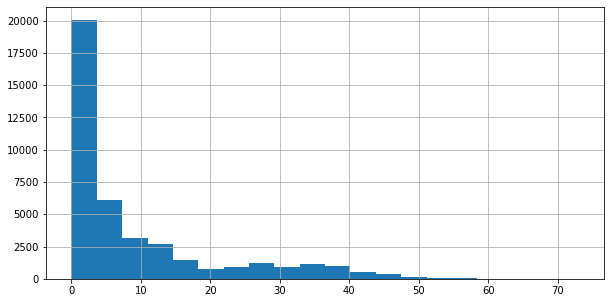

In [8]:
df2['Sales'].hist(bins=20, figsize=(10,5))
plt.show()

## 3 - Criando o modelo
    Agora que temos uma baseline, vamos tentar vencê-la!
    
Como primeiro modelo, vamos usar uma _random florest_. Além de ser um modelo forte com dados estruturados (como o que temos), geralmente já podemos obter um resultado muito bom apenas definindo um número alto de estimadores/árvores.

In [15]:
mean_error = []
for week in range(40,52):
    train = df2[df2['Week'] < week]
    validation = df2[df2['Week'] == week]
    
    train_X, test_X = train.drop(['Sales'], axis=1), validation.drop(['Sales'], axis=1)
    train_y, test_y = train['Sales'].values, validation['Sales'].values
    
    # Modelo --> RandomForestRegressor()
    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    
    # Treinando/ Fazendo o modelo aprender os padrões nos dados
    model.fit(train_X, train_y)
    
    #Passando os dados/as features de teste (que ele nunca viu) para usar o padrão aprendido na predição dos valores Y de teste 
    prediction = model.predict(test_X)
    
    # Calculando o erro para avaliarmos sua precisão
    error = rmsle(test_y, prediction)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)

print('\nMean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.46242
Week 41 - Error 0.45964
Week 42 - Error 0.46166
Week 43 - Error 0.46655
Week 44 - Error 0.47122
Week 45 - Error 0.43100
Week 46 - Error 0.47183
Week 47 - Error 0.44945
Week 48 - Error 0.46080
Week 49 - Error 0.44696
Week 50 - Error 0.47465
Week 51 - Error 0.48651

Mean Error = 0.46189


### Melhorando-o

Aplicando RandomForest conseguimos reduzir a porcentagem de erros. 

Agora, vamos ver o que conseguimos ao adicionar algumas features de mais semanas no passado.

Mas antes, vamos adicionar o atraso e a diferença de vendas da semana anterior e da penúltima semana.

In [16]:
df2.head() # E para comparar, aqui esta o dataset que acabamos de usar.

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0


In [17]:
# Os processos são praticamente os mesmos já visto antes.
df3 = df.copy()
df3['Last_Week_Sales'] = df3.groupby(['Product_Code'])['Sales'].shift()
df3['Last_Week_Diff'] = df3.groupby(['Product_Code'])['Last_Week_Sales'].diff()
df3['Last-1_Week_Sales'] = df3.groupby(['Product_Code'])['Sales'].shift(2)
df3['Last-1_Week_Diff'] = df3.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
df3 = df3.dropna()
df3.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff
2433,1,3,8,10.0,-2.0,12.0,1.0
2434,2,3,2,3.0,-3.0,6.0,-1.0
2435,3,3,9,8.0,-3.0,11.0,4.0
2436,4,3,5,13.0,5.0,8.0,-4.0
2437,5,3,11,13.0,8.0,5.0,-3.0


**Então treinamos mais um modelo, agora usando as variáveis antigas junto às novas.**

In [18]:
mean_error = []
for week in range(40,52):
    train = df3[df3['Week'] < week]
    validation = df3[df3['Week'] == week]
    
    train_X, test_X = train.drop(['Sales'], axis=1), validation.drop(['Sales'], axis=1)
    train_y, test_y = train['Sales'].values, validation['Sales'].values
    
    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    model.fit(train_X, train_y)
    
    prediction = model.predict(test_X)
    
    error = rmsle(test_y, prediction)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)

print('\nMean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.44389
Week 41 - Error 0.45812
Week 42 - Error 0.43652
Week 43 - Error 0.44033
Week 44 - Error 0.46318
Week 45 - Error 0.42361
Week 46 - Error 0.45752
Week 47 - Error 0.44533
Week 48 - Error 0.44598
Week 49 - Error 0.43538
Week 50 - Error 0.47349
Week 51 - Error 0.46487

Mean Error = 0.44902


Outra redução. Então por que não tentar um modelo com mais um atraso e diferença?

In [19]:
df4 = df.copy()
df4['Last_Week_Sales'] = df4.groupby(['Product_Code'])['Sales'].shift()
df4['Last_Week_Diff'] = df4.groupby(['Product_Code'])['Last_Week_Sales'].diff()
df4['Last-1_Week_Sales'] = df4.groupby(['Product_Code'])['Sales'].shift(2)
df4['Last-1_Week_Diff'] = df4.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
df4['Last-2_Week_Sales'] = df4.groupby(['Product_Code'])['Sales'].shift(3)
df4['Last-2_Week_Diff'] = df4.groupby(['Product_Code'])['Last-2_Week_Sales'].diff()
df4 = df4.dropna()
df4.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
3244,1,4,13,8.0,-2.0,10.0,-2.0,12.0,1.0
3245,2,4,7,2.0,-1.0,3.0,-3.0,6.0,-1.0
3246,3,4,10,9.0,1.0,8.0,-3.0,11.0,4.0
3247,4,4,9,5.0,-8.0,13.0,5.0,8.0,-4.0
3248,5,4,6,11.0,-2.0,13.0,8.0,5.0,-3.0


In [20]:
mean_error = []
for week in range(40,52):
    train = df4[df4['Week'] < week]
    validation = df4[df4['Week'] == week]
    
    train_X, test_X = train.drop(['Sales'], axis=1), validation.drop(['Sales'], axis=1)
    train_y, test_y = train['Sales'].values, validation['Sales'].values
                                # menos n_estimators
    model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
    model.fit(train_X, train_y)
    
    prediction = model.predict(test_X)
    
    error = rmsle(test_y, prediction)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)

print('\nMean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.43286
Week 41 - Error 0.43986
Week 42 - Error 0.43061
Week 43 - Error 0.42074
Week 44 - Error 0.45081
Week 45 - Error 0.41358
Week 46 - Error 0.44129
Week 47 - Error 0.43286
Week 48 - Error 0.43838
Week 49 - Error 0.43048
Week 50 - Error 0.46058
Week 51 - Error 0.45568

Mean Error = 0.43731


Perceba que mesmo com bem menos estimadores (de 1000 para 100) ainda há redução de erros.

Se continuarmos nesse processo, chegaremos a um limite de redução e podendo até aumentar os erros, por isso, agora focaremos em diminuir o erro com outras estratégias.

## Modificando a variável alvo
        Melhor distribuindo a variável alvo para obter melhores retornos.
        
        Basicamente, ao invés de prever o número original/o número bruto de quantas unidades foram
        vendidas, vamos prever o log do número de unidades. Pois ao tirar o log a distribuição da váriavel 
        mudará, facilitando para o modelo encontrar padrões. 

Analisando a tabela de logaritmos dá para perceber a mudança que ocorre. Se bem que para não termos problemas com 0 utiliza-se .log1p(), assim ele somará 1 antes de fazer o log (já que se alguma variável tiver o valor igual a zero, teremos problemas, assim 0+1=1, logo o retorno será log de 1 que é 0).

Tabela de logaritmo: https://raw.githubusercontent.com/pauloreis-ds/Paulo-Reis-Ciencia-de-dados/master/3%20-%20An%C3%A1lise%20de%20dados%20(com%20Machine%20Learning)%20-%20Data%20Analysis%20(Machine%20Learning)/Previs%C3%A3o%20de%20demanda/adicional/tabua-logaritmos.bmp

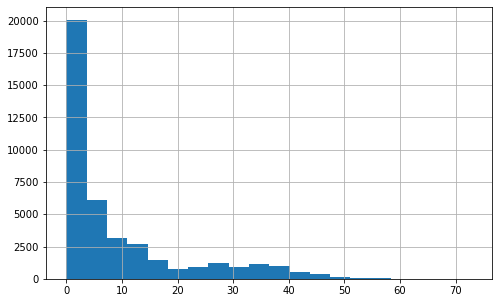

In [26]:
# Distribuição de vendas dos dados, percebemos que muitos itens vendem quantidades muito pequenas.
df2['Sales'].hist(bins=20, figsize=(8,5))
plt.show()

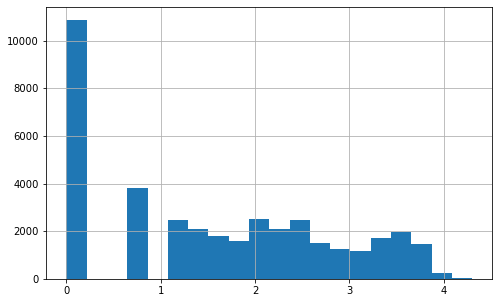

In [27]:
# Note como os dados estão mais distribuídos, após aplicarmos a função log 
np.log1p(df4.Sales).hist(bins=20, figsize=(8,5))
plt.show()

In [22]:
mean_error = []
for week in range(40,52):
    train = df4[df4['Week'] < week]
    validation = df4[df4['Week'] == week]
    
    train_X, test_X = train.drop(['Sales'], axis=1), validation.drop(['Sales'], axis=1)
    train_y, test_y = train['Sales'].values, validation['Sales'].values
    
    model = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=0)
    
    # Modificando nosso alvo
    model.fit(train_X, np.log1p(train_y)) 
    
    # Transformando as previsões do modelo em valores que façam sentido para nós, em outras palavras deslogando o modelo
    prediction = np.expm1(model.predict(test_X)) 
    
    error = rmsle(test_y, prediction)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)

print('\nMean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.41729
Week 41 - Error 0.42244
Week 42 - Error 0.41291
Week 43 - Error 0.40411
Week 44 - Error 0.43460
Week 45 - Error 0.39733
Week 46 - Error 0.42591
Week 47 - Error 0.41201
Week 48 - Error 0.43050
Week 49 - Error 0.43626
Week 50 - Error 0.44554
Week 51 - Error 0.47273

Mean Error = 0.42597


## Um modelo melhor
**Outra opção para conseguir melhores resultados é utilizando modelos mais avançados, como por exemplo o LGBMRegressor, o que também é um modelo de árvore, mas ele tem uma abordagem diferente da RandomForest**

In [28]:
mean_error = []
for week in range(40,52):
    train = df4[df4['Week'] < week]
    validation = df4[df4['Week'] == week]
    
    train_X, test_X = train.drop(['Sales'], axis=1), validation.drop(['Sales'], axis=1)
    train_y, test_y = train['Sales'].values, validation['Sales'].values
    
    model = LGBMRegressor(n_estimators=500, learning_rate=0.01)
    model.fit(train_X, np.log1p(train_y))
    
    prediction = np.expm1(model.predict(test_X))
    
    error = rmsle(test_y, prediction)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)

print('\nMean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.40835
Week 41 - Error 0.39895
Week 42 - Error 0.39485
Week 43 - Error 0.39366
Week 44 - Error 0.42093
Week 45 - Error 0.37787
Week 46 - Error 0.40440
Week 47 - Error 0.38931
Week 48 - Error 0.39630
Week 49 - Error 0.40957
Week 50 - Error 0.42134
Week 51 - Error 0.45500

Mean Error = 0.40588


**Para finalizar, vamos dar uma olhada em nossas previsões para a semana 52:**<br>
Veremos que o modelo vai bem até produtos que são vendidos até 20 unidades, depois disso ele começa a embaçar.

In [45]:
prediction[0:5] # As previsões

array([5.05368656, 4.10682792, 8.89519601, 8.87745301, 7.29732768])

In [46]:
np.round(prediction[0:5]) # Arredondando seus valores

array([5., 4., 9., 9., 7.])

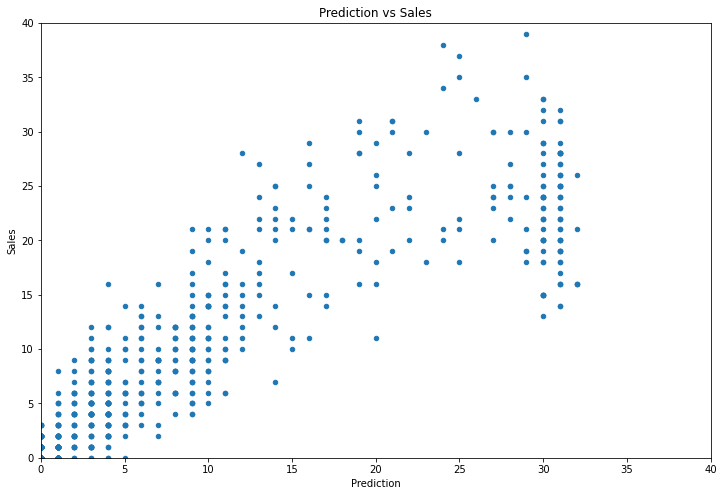

In [34]:
validation.loc[:, 'Prediction'] = np.round(prediction.copy())
validation.plot.scatter(x='Prediction', y='Sales', figsize=(12,8), title='Prediction vs Sales',ylim=(0,40), xlim=(0,40))
plt.show()

In [48]:
validation.head() # Todos os dados de Teste, incluindo as previsões

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff,Prediction
41361,1,51,10,5.0,-1.0,6.0,-1.0,7.0,4.0,5.0
41362,2,51,0,6.0,5.0,1.0,-4.0,5.0,1.0,4.0
41363,3,51,7,8.0,0.0,8.0,-6.0,14.0,6.0,9.0
41364,4,51,8,7.0,-1.0,8.0,-6.0,14.0,6.0,9.0
41365,5,51,9,8.0,-3.0,11.0,6.0,5.0,-1.0,7.0


No gráfico podemos perceber um "cluster" de produtos que têm cerca de 30 vendas por dia em que nosso modelo não prevê. Definitivamente, devemos investigar esse grupo, entender por que isso está acontecendo e ver se podemos ajustar nosso modelo a isso.

Faltam informações? Talvez estes sejam produtos comprados a granel? Ou as unidades são diferentes (libras vs onças)? Podemos formular hipóteses e então investigá-las.

## Melhorando a solução
Algumas ideias para tentar melhorar esta solução:

- Investigar produtos com vendas acima de 25 unidades.
- Testar com mais features (atrasos, diferenças) não apenas no nível do produto, mas no global.
- Tentar usar o suporte nativo do LightGBM para recursos categóricos com o Código do produto.
- Tentar ajustar os hiperparâmetros do modelo.
- Experimentar uma rede neural e fazer conjunto com o GBM.